In [0]:
def generate_bigrams(x):
    n_grams = set(zip(*[x[i:] for i in range(2)]))
    for n_gram in n_grams:
        x.append(' '.join(n_gram))
    return x

In [3]:

generate_bigrams(['This', 'film', 'is', 'terrible'])

['This', 'film', 'is', 'terrible', 'film is', 'is terrible', 'This film']

In [0]:
import torch
from torchtext import data
from torchtext import datasets

SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize='spacy', preprocessing=generate_bigrams) #define how the review should be processed
LABEL = data.LabelField(dtype=torch.float) #used to process the sentiment

In [5]:
import random

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL) #get dataset

train_data, valid_data = train_data.split(random_state=random.seed(SEED)) #split trainset to train/valid
#pass the seed to get the same split each time

aclImdb_v1.tar.gz:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:02<00:00, 35.6MB/s]


In [0]:
TEXT.build_vocab(train_data, max_size=25000, vectors="glove.6B.100d") 
LABEL.build_vocab(train_data)
#build vocab while keeping 25,000/100,000 most frequent words
#pass argument to download pre trained vectors

In [0]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #place tensors on GPU

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE, 
    device=device)
# create the iterators to go over in the test/validation step
# use bucket iterator which will batch similar length sentences to cut down on padding

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class FastText(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)
        
    def forward(self, x):
        
        #x = [sent len, batch size]
        
        embedded = self.embedding(x)
                
        #embedded = [sent len, batch size, emb dim]
        
        embedded = embedded.permute(1, 0, 2)
        
        #embedded = [batch size, sent len, emb dim]
        
        pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1) 
        
        #pooled = [batch size, embedding_dim]
                
        return self.fc(pooled)

In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
OUTPUT_DIM = 1

model = FastText(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM) #create an instance of the FastText class

In [11]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings) #load pre train embeddings to emb' layer

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [0]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())  #set optimizer do updtae parameters
criterion = nn.BCEWithLogitsLoss() #define the loss function
model = model.to(device) #load to GPU
criterion = criterion.to(device) #load to GPU

In [0]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds)) #squase [0,1] and round to close int
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct) #how many rounded prediction match the label avg accross a batch
    return acc

In [0]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train() #set to train mode, turns dropout on altough we are not using it
    
    for batch in iterator:
        
        optimizer.zero_grad() #zero out grad att - pytorch does not do it auto' zero after the last calc'
        
        predictions = model(batch.text).squeeze(1) # set to 1 dim [batch size] for loss func
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward() #calculate grad for each param
        
        optimizer.step() #updaet param'
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator) #loss/accuracy avg' across the epoch

In [0]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval() #set to eval mode -turns dropout off
    
    with torch.no_grad(): #no grad calc' in this block -do not update on evaluation
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1) # set to 1 dim [batch size] for loss func
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [16]:
N_EPOCHS = 5
train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []

for epoch in range(N_EPOCHS):

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracy.append(train_acc)
    valid_accuracy.append(valid_acc)
    
    
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

| Epoch: 01 | Train Loss: 0.687 | Train Acc: 56.97% | Val. Loss: 0.639 | Val. Acc: 69.16% |
| Epoch: 02 | Train Loss: 0.653 | Train Acc: 70.04% | Val. Loss: 0.510 | Val. Acc: 76.08% |
| Epoch: 03 | Train Loss: 0.580 | Train Acc: 78.83% | Val. Loss: 0.445 | Val. Acc: 79.58% |
| Epoch: 04 | Train Loss: 0.503 | Train Acc: 83.28% | Val. Loss: 0.407 | Val. Acc: 82.99% |
| Epoch: 05 | Train Loss: 0.436 | Train Acc: 86.11% | Val. Loss: 0.382 | Val. Acc: 85.81% |


In [17]:
test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')

| Test Loss: 0.393 | Test Acc: 85.08% |


In [0]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)] #tokanize raw input
    indexed = [TEXT.vocab.stoi[t] for t in tokenized] #convet to indexed representation of vocab
    tensor = torch.LongTensor(indexed).to(device) #list to tensor
    tensor = tensor.unsqueeze(1) #add batch dim
    prediction = torch.sigmoid(model(tensor)) #squash prediction value [0,1]
    return prediction.item() #covnert tensor holding a single value to int

In [38]:

predict_sentiment("this is a great movie")

0.9999991655349731

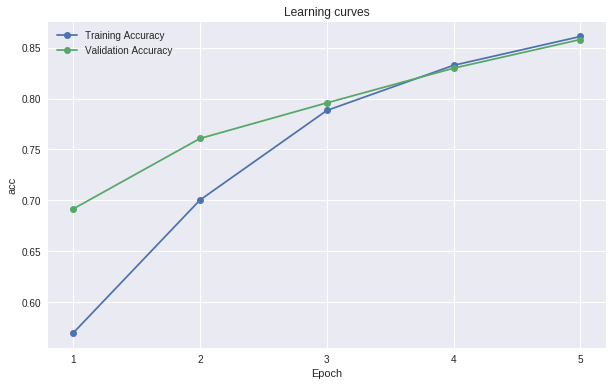

In [36]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, train_accuracy, '-o', label='Training Accuracy')
plt.plot(epochs, valid_accuracy, '-o', label='Validation Accuracy')
plt.legend()
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('acc')
plt.xticks(epochs)
plt.show()